In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout
warnings.filterwarnings('ignore')

In [ ]:
test =pd.read_csv('/content/data_test_24-29.csv')
train = pd.read_csv('/content/data_train_24-29 (1).csv')



In [ ]:
train_data = train.drop(['TIME IN GMT','TIME IN IST','Lat ','Long', 'Time','T','Date'], axis=1)
test_data = test.drop(['TIME IN GMT','TIME IN IST','Lat ','Long', 'Time','T','Date'], axis=1)



In [ ]:
train_data.dropna(axis=0, how='any', inplace=True)
train_data.shape

(178283, 8)

In [ ]:
test_data.dropna(axis=0, how='any', inplace=True)
test_data.shape

(44574, 8)

In [ ]:
n_time_steps = 104
n_features = 7 
step = 104
n_classes = 5 
n_epochs = 50       
batch_size = 32   
learning_rate = 0.0001
l2_loss = 0.0015

segments = []
labels = []


In [ ]:
for i in range(0,  train_data.shape[0]- n_time_steps, step):  

    Ax_tr = train_data['Ax'].values[i: i + n_time_steps]

    Ay_tr = train_data['Ay'].values[i: i + n_time_steps]

    Az_tr = train_data['Az'].values[i: i + n_time_steps]

    Gx_tr = train_data['Gx'].values[i: i + n_time_steps]

    Gy_tr = train_data['Gy'].values[i: i + n_time_steps]

    Gz_tr = train_data['Gz'].values[i: i + n_time_steps]

    Speed_tr = train_data['Speed'].values[i: i + n_time_steps]


    label_tr = stats.mode(train_data['Label'][i: i + n_time_steps])[0][0]

    segments.append([Ax_tr, Ay_tr, Az_tr, Gx_tr,Gy_tr,Gz_tr,Speed_tr])

    labels.append(label_tr)

In [ ]:
X_train = np.asarray(segments, dtype= np.float32).reshape(-1, n_time_steps, n_features)

y_train = np.asarray(pd.get_dummies(labels), dtype = np.float32)

X_train.shape

(1714, 104, 7)

In [ ]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, n_time_steps, n_features)

In [ ]:
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

reshaped_segments.shape

(1714, 104, 7)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.25)


In [ ]:

import os
from tensorflow.keras import Input
from tensorflow.keras.models import load_model, Model

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate, Layer

# KERAS_ATTENTION_DEBUG: If set to 1. Will switch to debug mode.
# In debug mode, the class Attention is no longer a Keras layer.
# What it means in practice is that we can have access to the internal values
# of each tensor. If we don't use debug, Keras treats the object
# as a layer and we can only get the final output.
debug_flag = int(os.environ.get('KERAS_ATTENTION_DEBUG', 0))


class Attention(object if debug_flag else Layer):

    def __init__(self, units=128, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.units = units

    # noinspection PyAttributeOutsideInit
    def build(self, input_shape):
        input_dim = int(input_shape[-1])
        with K.name_scope(self.name if not debug_flag else 'attention'):
            self.attention_score_vec = Dense(input_dim, use_bias=False, name='attention_score_vec')
            self.h_t = Lambda(lambda x: x[:, -1, :], output_shape=(input_dim,), name='last_hidden_state')
            self.attention_score = Dot(axes=[1, 2], name='attention_score')
            self.attention_weight = Activation('softmax', name='attention_weight')
            self.context_vector = Dot(axes=[1, 1], name='context_vector')
            self.attention_output = Concatenate(name='attention_output')
            self.attention_vector = Dense(self.units, use_bias=False, activation='tanh', name='attention_vector')
        if not debug_flag:
            # debug: the call to build() is done in call().
            super(Attention, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units

    def __call__(self, inputs, training=None, **kwargs):
        if debug_flag:
            return self.call(inputs, training, **kwargs)
        else:
            return super(Attention, self).__call__(inputs, training, **kwargs)

    # noinspection PyUnusedLocal
    def call(self, inputs, training=None, **kwargs):
        """
        Many-to-one attention mechanism for Keras.
        @param inputs: 3D tensor with shape (batch_size, time_steps, input_dim).
        @param training: not used in this layer.
        @return: 2D tensor with shape (batch_size, units)
        @author: felixhao28, philipperemy.
        """
        if debug_flag:
            self.build(inputs.shape)
        # Inside dense layer
        #              hidden_states            dot               W            =>           score_first_part
        # (batch_size, time_steps, hidden_size) dot (hidden_size, hidden_size) => (batch_size, time_steps, hidden_size)
        # W is the trainable weight matrix of attention Luong's multiplicative style score
        score_first_part = self.attention_score_vec(inputs)
        #            score_first_part           dot        last_hidden_state     => attention_weights
        # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
        h_t = self.h_t(inputs)
        score = self.attention_score([h_t, score_first_part])
        attention_weights = self.attention_weight(score)
        # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
        context_vector = self.context_vector([inputs, attention_weights])
        pre_activation = self.attention_output([context_vector, h_t])
        attention_vector = self.attention_vector(pre_activation)
        return attention_vector

    def get_config(self):
        """
        Returns the config of a the layer. This is used for saving and loading from a model
        :return: python dictionary with specs to rebuild layer
        """
        config = super(Attention, self).get_config()
        config.update({'units': self.units})
        return config

In [ ]:
model_input = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = LSTM(120, return_sequences=True, dropout=0.1)(model_input)
x = Attention(units=32)(x)
x = Dense(units = 64, activation='tanh')(x)
x = Dense(y_train.shape[1], activation = 'softplus')(x)
model = Model(model_input, x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 104, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 104, 120)          61440     
                                                                 
 attention (Attention)       (None, 32)                22080     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 85,957
Trainable params: 85,957
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(X_test.shape)
print(y_test.shape)

(429, 104, 7)
(429, 5)


In [ ]:

history = model.fit(X_train, y_train, epochs = n_epochs, validation_data = (X_test, y_test), batch_size = 32, verbose = 1)

#history = model.fit(X_train, y_train, epochs = n_epochs, validation_data = (X_test, y_test), batch_size = batch_size, verbose = 1)


Epoch 1/50
41/41 [==============================] - 12s 232ms/step - loss: 0.7295 - accuracy: 0.8008 - val_loss: 0.5718 - val_accuracy: 0.8392
Epoch 2/50
41/41 [==============================] - 10s 233ms/step - loss: 0.5207 - accuracy: 0.8280 - val_loss: 0.3896 - val_accuracy: 0.8392
Epoch 3/50
41/41 [==============================] - 11s 270ms/step - loss: 0.3971 - accuracy: 0.8545 - val_loss: 0.3080 - val_accuracy: 0.8788
Epoch 4/50
41/41 [==============================] - 12s 284ms/step - loss: 0.3534 - accuracy: 0.8872 - val_loss: 0.3241 - val_accuracy: 0.8928
Epoch 5/50
41/41 [==============================] - 6s 145ms/step - loss: 0.3096 - accuracy: 0.8973 - val_loss: 0.2389 - val_accuracy: 0.9277
Epoch 6/50
41/41 [==============================] - 5s 116ms/step - loss: 0.3039 - accuracy: 0.9004 - val_loss: 0.2381 - val_accuracy: 0.9207
Epoch 7/50
41/41 [==============================] - 5s 117ms/step - loss: 0.2493 - accuracy: 0.9230 - val_loss: 0.2166 - val_accuracy: 0.9324
Ep

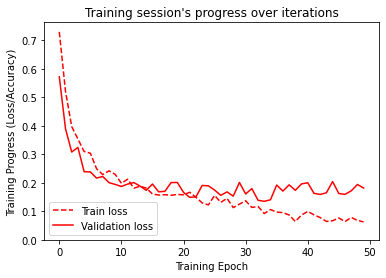

In [ ]:
plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
# plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
# plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0) 
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
print("Test Accuracy :", accuracy)
print("Test Loss :", loss)

14/14 [==============================] - 1s 54ms/step - loss: 0.1815 - accuracy: 0.9510
Test Accuracy : 0.9510489702224731
Test Loss : 0.1814655065536499


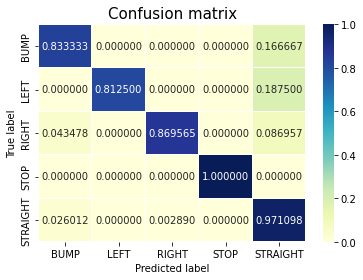

In [ ]:
import sklearn.metrics as metrics

predictions = model.predict(X_test)
class_labels = ['BUMP', 'LEFT',  'RIGHT','STOP', 'STRAIGHT']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, xticklabels = class_labels, yticklabels = class_labels, annot = True, linewidths = 0.1, fmt='2f', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()